# Modélisation 

### Import des modules 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance



#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

En règle générale : On utilise la méthode .apply() de Pandas pour créer une nouvelle colonne à partir d'une colonne existante. N'hésitez pas à regarder les exemples dans les chapitres de cours donnés en ressource

In [13]:
# CODE FEATURE ENGINEERING
building_consumption = pd.read_csv("../assets/building_consumption_post_EDA.csv")
print(	
	(
    building_consumption["ListOfAllPropertyUseTypes"].isna()
    | (building_consumption["ListOfAllPropertyUseTypes"].str.strip() == "")
).sum())
# building_consumption.info()

2


## 1. Nouvelles features sur le type d'usage

### A partir des informations sur les types d'usage des bâtiments et leurs surfaces associées, identifier le top 10 des types d'usage les plus fréquents dans le dataset et créer une nouvelle feature binaire (0/1) pour chacun de ces types d'usage, indiquant si le bâtiment a ce type d'usage ou pas.


In [14]:
feature = "LargestPropertyUseType"

# Supprimer les NaN pour éviter les erreurs
types = building_consumption[feature].dropna()

# Découper par ",", nettoyer les espaces
all_types = types.apply(lambda x: [t.strip() for t in x.split(",")])

# Aplatir la liste
unique_types = set([t for sublist in all_types for t in sublist])

# Nombre d'usages uniques
print(f"Nombre d'usages distincts : {len(unique_types)}")

# Liste des usages
print(unique_types)

Nombre d'usages distincts : 60
{'Non-Refrigerated Warehouse', 'Manufacturing/Industrial Plant', 'Medical Office', 'Other - Recreation', 'Other', 'Residential Care Facility', 'Other/Specialty Hospital', 'Self-Storage Facility', 'Courthouse', 'Shoe', 'Strip Mall', 'Locksmith', 'Laboratory', 'Automobile Dealership', 'Worship Facility', 'Fitness Center/Health Club/Gym', 'Museum', 'Residence Hall/Dormitory', 'Prison/Incarceration', 'Repair Services (Vehicle', 'Other - Entertainment/Public Assembly', 'Library', 'Financial Office', 'Other - Services', 'Bank Branch', 'Pre-school/Daycare', 'Data Center', 'Supermarket/Grocery Store', 'Office', 'K-12 School', 'Food Service', 'Urgent Care/Clinic/Other Outpatient', 'Distribution Center', 'Other - Restaurant/Bar', 'Performing Arts', 'Hospital (General Medical & Surgical)', 'Multifamily Housing', 'Adult Education', 'Fire Station', 'etc)', 'Movie Theater', 'Police Station', 'Other - Utility', 'Other - Mall', 'Retail Store', 'Social/Meeting Hall', 'Who

In [15]:
# On récupère les colonnes d'usage et de surface
use_cols = [
    "LargestPropertyUseType",
    "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType",
]
gfa_cols = [
    "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA",
]

# Construire un DataFrame "long" pour sommer les surfaces par type d'usage
usage_long = pd.DataFrame(
    {
        "Usage": pd.concat(
            [building_consumption[col] for col in use_cols], ignore_index=True
        ),
        "GFA": pd.concat(
            [building_consumption[col] for col in gfa_cols], ignore_index=True
        ),
    }
)

# Supprimer les NaN
usage_long = usage_long.dropna()

# Somme des surfaces par usage
usage_summary = usage_long.groupby("Usage")["GFA"].sum().sort_values(ascending=False)

# Top 10 usages
top_usage = usage_summary.head(10)
print(top_usage)

Usage
Office                                   6.269492e+07
Parking                                  2.368383e+07
Non-Refrigerated Warehouse               1.161317e+07
Hotel                                    1.080014e+07
K-12 School                              1.059569e+07
Retail Store                             8.293456e+06
Other                                    7.761624e+06
Hospital (General Medical & Surgical)    6.940263e+06
Medical Office                           4.752608e+06
Other - Entertainment/Public Assembly    4.354264e+06
Name: GFA, dtype: float64


In [16]:
# Surface totale de tous les usages
total_gfa_all = usage_long["GFA"].sum()

# Surface cumulée des top 10 usages
total_gfa_top10 = top_usage.sum()

# Pourcentage
pct_top10 = total_gfa_top10 / total_gfa_all * 100
print(f"Les top 10 usages représentent {pct_top10:.2f}% de la surface totale.")

Les top 10 usages représentent 83.17% de la surface totale.


In [17]:
# Créer des colonnes binaires pour chaque usage dans le DataFrame original
for usage in top_usage.index:
    # 1 si usage présent dans l'une des 3 colonnes, 0 sinon
    building_consumption[usage] = (
        building_consumption[use_cols].isin([usage]).any(axis=1).astype(int)
    )
# Supprimer les colonnes d'usage originales et les surfaces associées   
building_consumption.drop(columns=use_cols + gfa_cols, inplace=True)

# Vérifier
building_consumption.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Office,Parking,Non-Refrigerated Warehouse,Hotel,K-12 School,Retail Store,Other,Hospital (General Medical & Surgical),Medical Office,Other - Entertainment/Public Assembly
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,0,0,0,1,0,0,0,0,0,0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,0,1,0,1,0,0,0,0,0,0
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,0,0,0,1,0,0,0,0,0,0
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,0,0,0,1,0,0,0,0,0,0
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,0,1,0,1,0,0,0,0,0,0


## 2. Modification de la feature "NumberofFloors"

### Création de quintiles (méthode pd.qcut()) pour la feature "NumberofFloors" et suppression de la colonne originale.

In [18]:
building_consumption["NumberofFloors"].describe()

count    1627.000000
mean        4.159803
std         6.634568
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        99.000000
Name: NumberofFloors, dtype: float64

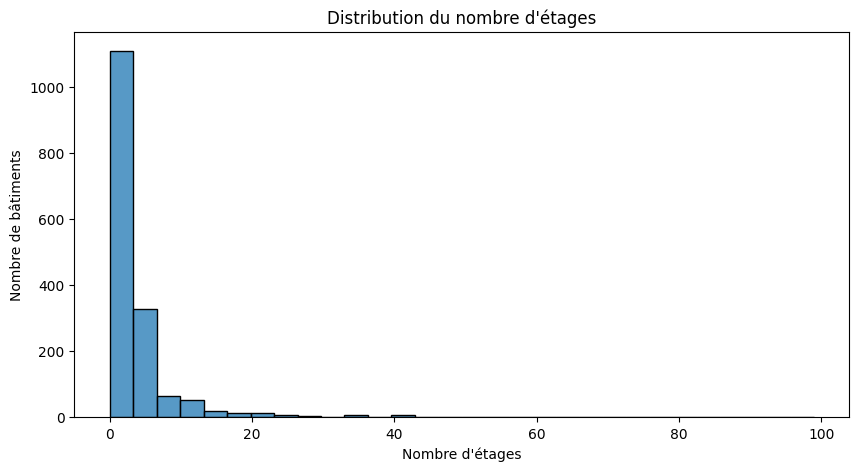

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(building_consumption["NumberofFloors"], bins=30, kde=False)
plt.title("Distribution du nombre d'étages")
plt.xlabel("Nombre d'étages")
plt.ylabel("Nombre de bâtiments")
plt.show()

In [20]:
# Créer des quintiles pour "NumberofFloors"
# et afficher le nombre de bâtiments dans chaque quintile
building_consumption["NumberofFloors_quintile"] = pd.qcut(building_consumption["NumberofFloors"], q=5, labels=False)
print(building_consumption["NumberofFloors_quintile"].value_counts())

# Supprimer la colonne originale
building_consumption.drop(columns=["NumberofFloors"], inplace=True)

NumberofFloors_quintile
0    471
1    376
4    275
2    262
3    243
Name: count, dtype: int64


## 3. Nouvelles features sur les types d'énergie utilisés

### Création de variables indicatrices (0/1) pour indiquer si le bâtiment utilise ou pas chacun des types d'énergie suivants : "Electricity(kBtu)", "NaturalGas(kBtu)", "SteamUse(kBtu)". Pour cela, on crée une nouvelle colonne pour chaque type d'énergie, avec la valeur 1 si la consommation est supérieure à 0, et 0 sinon. On supprime ensuite les colonnes originales.

In [21]:
building_consumption.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Office', 'Parking',
       'Non-Refrigerated Warehouse', 'Hotel', 'K-12 School', 'Retail Store',
       'Other', 'Hospital (General Medical & Surgical)', 'Medical Office',
    

In [22]:
energy_features = ["SteamUse(kBtu)", "NaturalGas(kBtu)", "Electricity(kBtu)"]
for energy in energy_features:
    building_consumption[energy.replace("(kBtu)", "").strip()] = (
        building_consumption[energy] > 0
    ).astype(int)

# Supprimer les colonnes originales
building_consumption.drop(columns=energy_features, inplace=True)
building_consumption["SteamUse"].head()

0    1
1    0
2    1
3    1
4    0
Name: SteamUse, dtype: int64

In [23]:
### Dataset post feature engineering
building_consumption.to_csv("../assets/building_consumption_post_feature_engineering.csv", index=False)